--- 데이터 확인 (처음 5개) ---
  x1: [1 3 5 7 9]
  x2: [ 2  4  6  8 10]

lab4-1: 1큐빗 Angle Encoding -- 주기 반복 문제
  x1=1  -> <Z> = 0.5403
  x1=99 -> <Z> = 0.0398
  문제: 서로 다른 x1이 같은 <Z>로 매핑됨 (주기 반복)


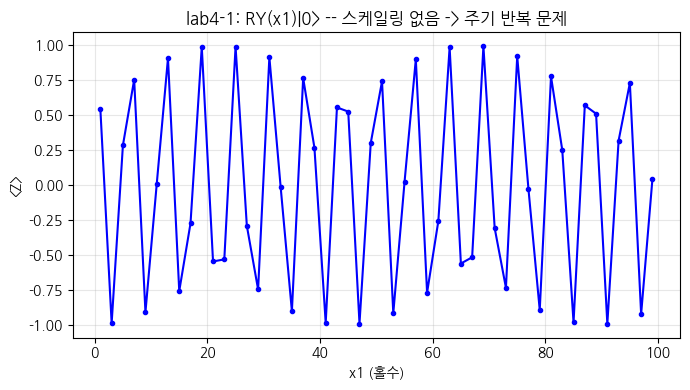


lab4-2: 스케일링 비교
  scale_max = 3.1416
  스케일링 없음: x1=1 -> 0.5403,  x1=99 -> 0.0398
  min-max 적용: x1=1 -> 1.0000,  x1=99 -> -0.9995


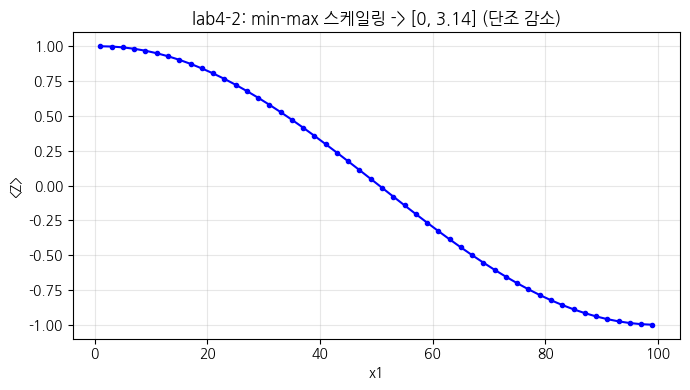

  - 스케일링 없음: 주기 반복 -> 서로 다른 x1이 같은 상태로 매핑
  - min-max [0, 3.14]: 단조 감소 -> x1이 커질수록 <Z> 감소 (구별 가능)

lab4-3: 2큐빗 AngleEmbedding + CNOT
  대상 샘플: x1=51, x2=52
  스케일 후: x1_sc=1.5867, x2_sc=1.6184


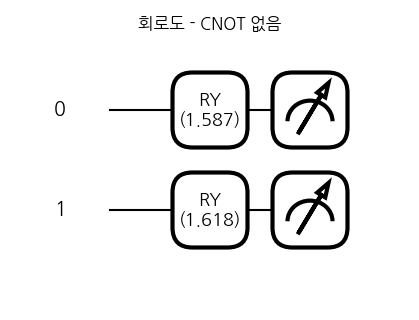

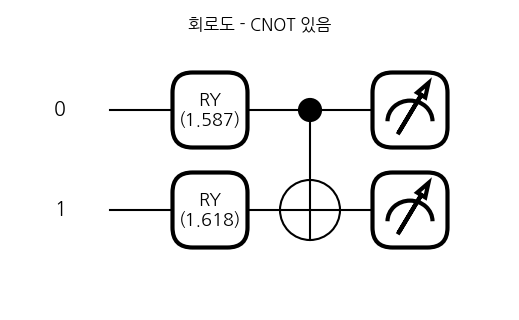


  CNOT 없음: ['0.234', '0.258', '0.242', '0.266']
  CNOT 있음: ['0.234', '0.258', '0.266', '0.242']


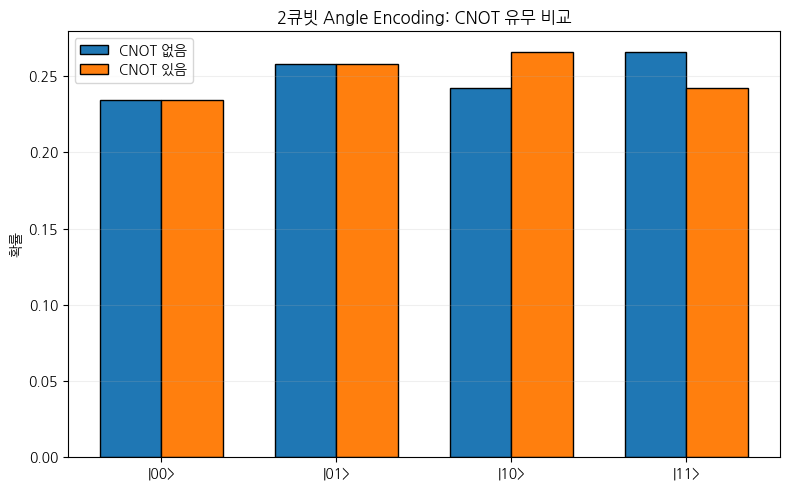


핵심:
CNOT 없음 → 두 큐빗 독립
CNOT 있음 → 확률 재배치 → 상호작용 생성


In [1]:
# !pip install pennylane koreanize_matplotlib -q
import pennylane as qml
from pennylane import numpy as np
import numpy as std_np
import matplotlib.pyplot as plt
import koreanize_matplotlib
plt.rcParams['axes.unicode_minus'] = False

# ============================================================
# ===== 학생 수정 영역 =====
scale_max = np.pi
# 추천: pi/2 -> 범위 좁음 / pi -> 기본값 / 2*pi -> 주기 반복 재현
idx_sample = 25
# 추천: 0 ~ 49 사이 정수, CNOT 유무 비교 대상 샘플
# ===== 수정 끝 =====
# ============================================================

# --- 데이터 ---
x1 = np.array([2*i + 1   for i in range(50)])    # 홀수: 1, 3, ..., 99
x2 = np.array([2*(i + 1) for i in range(50)])    # 짝수: 2, 4, ..., 100

print("--- 데이터 확인 (처음 5개) ---")
print(f"  x1: {x1[:5]}")
print(f"  x2: {x2[:5]}")

dev1 = qml.device("default.qubit", wires=1)
dev2 = qml.device("default.qubit", wires=2)

# ===========================================================
#  4-1: 1큐빗 Angle Encoding -- 주기 반복 문제
# ===========================================================

print("\n" + "=" * 60)
print("lab4-1: 1큐빗 Angle Encoding -- 주기 반복 문제")
print("=" * 60)

@qml.qnode(dev1)
def encode_ry(x):
    qml.RY(x, wires=0)
    return qml.expval(qml.PauliZ(0))

ry_vals = [float(encode_ry(x)) for x in x1]

print(f"  x1=1  -> <Z> = {float(encode_ry(1.0)):.4f}")
print(f"  x1=99 -> <Z> = {float(encode_ry(99.0)):.4f}")
print(f"  문제: 서로 다른 x1이 같은 <Z>로 매핑됨 (주기 반복)")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x1, ry_vals, 'bo-', ms=3)
ax.set_xlabel("x1 (홀수)")
ax.set_ylabel("<Z>")
ax.set_title("lab4-1: RY(x1)|0> -- 스케일링 없음 -> 주기 반복 문제")
ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ===========================================================
#  4-2: 스케일링 비교
# ===========================================================

print("\n" + "=" * 60)
print("lab4-2: 스케일링 비교")
print("=" * 60)

def scale(x, x_min=1, x_max=100):
    return (x - x_min) / (x_max - x_min) * scale_max

@qml.qnode(dev1)
def encode_scaled(x):
    qml.RY(x, wires=0)
    return qml.expval(qml.PauliZ(0))

results_raw    = [float(encode_scaled(float(x))) for x in x1]
results_minmax = [float(encode_scaled(scale(x)))  for x in x1]

print(f"  scale_max = {scale_max:.4f}")
print(f"  스케일링 없음: x1=1 -> {results_raw[0]:.4f},  x1=99 -> {results_raw[-1]:.4f}")
print(f"  min-max 적용: x1=1 -> {results_minmax[0]:.4f},  x1=99 -> {results_minmax[-1]:.4f}")

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x1, results_minmax, 'bo-', ms=3)
ax.set_xlabel("x1"); ax.set_ylabel("<Z>")
ax.set_title(f"lab4-2: min-max 스케일링 -> [0, {scale_max:.2f}] (단조 감소)")
ax.set_ylim(-1.1, 1.1); ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

print("  - 스케일링 없음: 주기 반복 -> 서로 다른 x1이 같은 상태로 매핑")
print(f"  - min-max [0, {scale_max:.2f}]: 단조 감소 -> x1이 커질수록 <Z> 감소 (구별 가능)")

# ===========================================================
#  4-3: 2큐빗 AngleEmbedding + CNOT
# ===========================================================

print("\n" + "=" * 60)
print("lab4-3: 2큐빗 AngleEmbedding + CNOT")
print("=" * 60)

@qml.qnode(dev2)
def encode_no_cnot(x1_val, x2_val):
    qml.RY(x1_val, wires=0)
    qml.RY(x2_val, wires=1)
    return qml.probs(wires=[0, 1])

@qml.qnode(dev2)
def encode_with_cnot(x1_val, x2_val):
    qml.RY(x1_val, wires=0)
    qml.RY(x2_val, wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.probs(wires=[0, 1])

x1_sc = float(scale(float(x1[idx_sample])))
x2_sc = float(scale(float(x2[idx_sample])))

print(f"  대상 샘플: x1={int(x1[idx_sample])}, x2={int(x2[idx_sample])}")
print(f"  스케일 후: x1_sc={x1_sc:.4f}, x2_sc={x2_sc:.4f}")

fig1, _ = qml.draw_mpl(encode_no_cnot,   decimals=3)(x1_sc, x2_sc)
fig1.suptitle("회로도 - CNOT 없음", fontsize=12)
plt.show()

fig2, _ = qml.draw_mpl(encode_with_cnot, decimals=3)(x1_sc, x2_sc)
fig2.suptitle("회로도 - CNOT 있음", fontsize=12)
plt.show()

p_no  = encode_no_cnot(x1_sc, x2_sc)
p_yes = encode_with_cnot(x1_sc, x2_sc)
basis = ["|00>", "|01>", "|10>", "|11>"]

print(f"\n  CNOT 없음: {[f'{v:.3f}' for v in p_no]}")
print(f"  CNOT 있음: {[f'{v:.3f}' for v in p_yes]}")


# 시각화
basis = ["|00>", "|01>", "|10>", "|11>"]
x_pos = std_np.arange(4)
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x_pos - width/2, p_no, width, label="CNOT 없음", edgecolor="k")
ax.bar(x_pos + width/2, p_yes, width, label="CNOT 있음", edgecolor="k")

ax.set_xticks(x_pos)
ax.set_xticklabels(basis)
ax.set_ylabel("확률")
ax.set_title("2큐빗 Angle Encoding: CNOT 유무 비교")
ax.legend()
ax.grid(True, alpha=0.2, axis="y")

plt.tight_layout()
plt.show()

print("\n핵심:")
print("CNOT 없음 → 두 큐빗 독립")
print("CNOT 있음 → 확률 재배치 → 상호작용 생성")
